In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision.all import *

import PIL
import torchvision

from pathlib import Path
from zipfile import ZipFile
import os

# import the requests library
import requests



import torch
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


from fastai.vision import *

import pandas as pd
import plotly.express as px

from gdeep.decision_boundary.decision_boundary_calculator import *
from gdeep.create_nets.sample_nn import Net, CircleNN
from gdeep.create_nets.utility import ToFastaiNN, ToPyTorchNN, PeriodicNeuralNetworkMaker
from gdeep.plotting.plot_decision_bdry import plot_activation_contours
from gdeep.create_data.tori import make_torus_point_cloud, Rotation, make_torus_dataset
from gdeep.create_nets.utility import train_classification_nn
from gdeep.decision_boundary.compute_boundary import GradientFlow, UniformlySampledPoint
from gdeep.plotting import plot_decision_boundary

np.random.seed(seed)

In [6]:
#URLs.MNIST_SAMPLE

In [7]:
# Download data set
#path = untar_data(URLs.MNIST)
# Very easy dataset
#path_dataset = untar_data(URLs.MNIST_SAMPLE)
#path_notebook = '/home/reinauer/EPFL/giotto-deep/examples'

In [10]:
path_dataset = "/home/jovyan/Innosuisse/giotto-deep/examples/datasets/mnist_sample"

In [11]:
# Create data block (Dataset + DataLoader)
digits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label
)
dls = digits.dataloaders(path_dataset, batch_size=512)

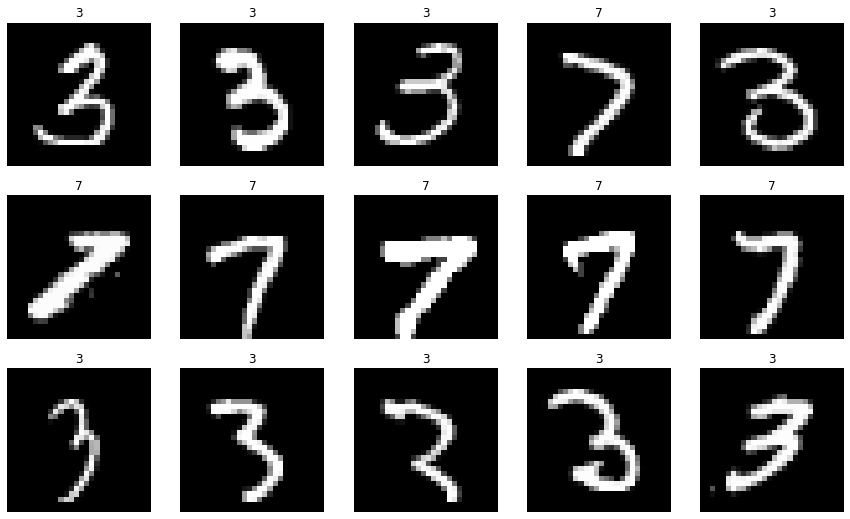

In [12]:
# Show sample digits
dls.valid.show_batch(max_n=15, nrows=3)

In [13]:
# Creat CNN Model
learn_18 = cnn_learner(dls, models.resnet18, metrics=[error_rate], pretrained=True, train_bn=False)
learn_18.fine_tune(1)
learn_18.export

epoch,train_loss,valid_loss,error_rate,time
0,0.625296,0.182467,0.070670,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.142400,0.070893,0.021709,00:07


<bound method Learner.export of <fastai.learner.Learner object at 0x7f9a6603c640>>

In [1]:
learn_18.export(fname='learn_18_mnist_sample.pkl')

NameError: name 'learn_18' is not defined

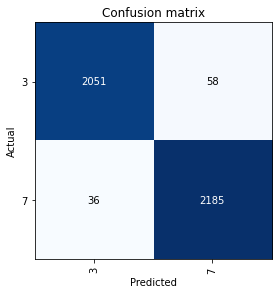

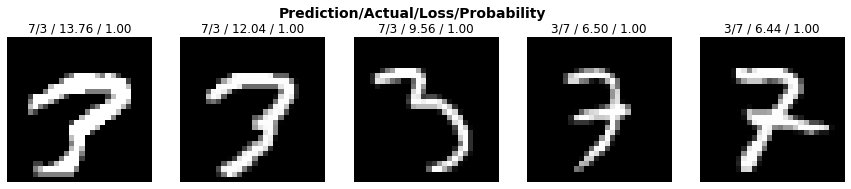

In [15]:
interp = ClassificationInterpretation.from_learner(learn_18)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [7]:
learn_18 = load_learner('resnet_18_simple.pkl')

In [8]:
learn_18.predict(torch.ones((28,28)))

In [9]:
path_dataset = Path(path_dataset)

NameError: name 'path_dataset' is not defined

In [10]:
threes = (path_dataset/'train/3').ls().sorted()
sevens = (path_dataset/'train/3').ls().sorted()

three_tensors = torch.stack([tensor(Image.open(o)) for o in threes]).float()/255
seven_tensors = torch.stack([tensor(Image.open(o)) for o in sevens]).float()/255

NameError: name 'path_dataset' is not defined

In [28]:
torch.save(three_tensors, 'three_tensors.pt')
torch.save(seven_tensors, 'seven_tensors.pt')

In [12]:
class ReshapeTo32(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.weight = torch.ones((3,1,1,1)).to(dev)

    def forward(self, x):
        return F.conv2d(x.view((-1, 28, 28)).unsqueeze(1),weight=self.weight, stride=1, padding=2)

In [13]:
reshaper = ReshapeTo32()
learn_18.model.to(dev)

model = nn.Sequential(reshaper, learn_18.model)


In [57]:
sum(p.numel() for p in learn_18.model.parameters())

11708992

In [223]:
n_samples = 100
g = GradientFlowDecisionBoundaryCalculator(
            model=model,
            initial_points=torch.distributions.uniform.Uniform(0.,1.).sample((n_samples, 28*28)).to(dev),
            optimizer=lambda params: torch.optim.Adam(params, )
)
#g.step(100)

In [49]:
f_val = model(g.get_decision_boundary()).detach().cpu()
y = torch.topk(f_val, 2).values
function_val = y[:, 0] - y[:, 1]
function_val = function_val.numpy()

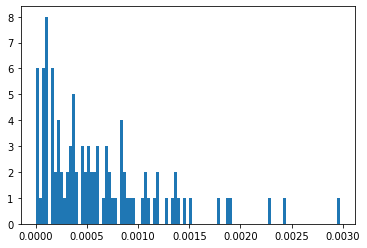

In [50]:
#function_val = model(g.get_decision_boundary()).detach().cpu().numpy()[:,0]

hist, _, _ =plt.hist(function_val, bins=101)
plt.show()

In [225]:
for step in range(100):
    g.step(1)
    sample_points = torch.clamp(g.get_decision_boundary().detach(), 0., 1.)
    sample_points_fval = torch.clamp(model(sample_points).detach(), 0., 1.).cpu().numpy()[:,0]

    pics = sample_points.cpu()

    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 9
    rows = 9
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        pic = pics[i].reshape((28,28)).numpy()
        pic_rgb = np.moveaxis(np.array([sample_points_fval[i]*pic, sample_points_fval[i]*pic, sample_points_fval[i]*pic]), 0,-1)
        #print(pic.min())
        #print(f'pic min:{pic_rgb.min()} --- {pics[i].min()}')
        plt.imshow(pic_rgb)
        plt.axis('off')
    #plt.show()
    print(f'step: {step} min: {sample_points_fval.min()}, max: {sample_points_fval.max()}')
    plt.savefig('/home/reinauer/EPFL/giotto-deep/examples/Gradient_Flow_Annimation/gradient_flow{:03d}.png'.format(step))

step: 0 min: 0.602145791053772, max: 1.0


FileNotFoundError: [Errno 2] No such file or directory: 'Gradient_Flow_Annimation/gradient_flow000.png'

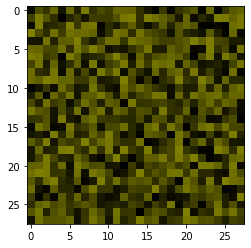

In [196]:
plt.imshow(pic_rgb*0.5)

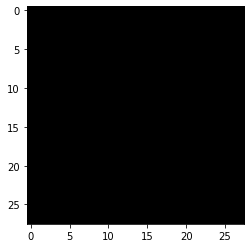

In [212]:
plt.imshow(np.ones((28,28,3))*np.arange(0,1,28))

In [106]:
function_val = model(g.get_filtered_decision_boundary(0.0000001)).detach().cpu().numpy()[:,0]
for i in range(1):
    plt.imshow(db_samples[i].reshape((28,28)),cmap='gray')
    plt.title(f"prediction:{function_val[i]}" )
    plt.show()

In [129]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

for step in range(1):
    g.step(1)
    sample_points = g.get_decision_boundary().detach()
    sample_points_fval = model(sample_points).detach().cpu().numpy()[:,0]
    
    pics = sample_points.cpu()
    rows=10
    cols=10
    fig = make_subplots(rows=rows, cols=cols,
        subplot_titles=[str(i) for i in range(rows*cols)]
        )

    for row in range(rows):
        for col in range(cols):
            fig.update_traces(px.imshow(pics[row*rows + col].reshape((28,28)), binary_string=True),
                    row=row, col=col)
            # title "{:.2f}".format(sample_points_fval[i])
    fig.show()

In [140]:
image_seq = [px.imshow(pics[i].reshape((28,28)))

In [74]:
db=torch.load('db_mnist_sample.pt')

In [75]:
db.shape

(9656, 784)

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(db)
bdry_pca = pca.transform(db)
df_bdry = pd.DataFrame(bdry_pca, columns = ["x"+str(i) for i in range(3)])

In [94]:
px.scatter_3d(df_bdry,x="x0",y="x1",z="x2")

In [95]:
df_bdry.shape

(9656, 3)